In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh, Dropout
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torch.distributions import Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily

from models import U_Net

bigger Feed forward net 

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 256
num_samples_train = 3000
input_shape = (batch_size, 1, 28, 28)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)
train_dataset_target = train_dataset.data[train_dataset.targets == 6][:num_samples_train].reshape((num_samples_train, 28 * 28)).to(device)

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)
test_dataset_init = test_dataset.data[test_dataset.targets == 8][:970].reshape((970, 28 * 28)).to(device)
test_dataset_target = test_dataset.data[test_dataset.targets == 6][:950].reshape((950, 1, 28, 28)).to(device)

In [4]:
pile_sampler = Categorical(torch.tensor([1]))
normal_init = MultivariateNormal(torch.tensor([[0 for i in range(28*28)]]).float(), 0.15*torch.stack([torch.eye(28*28) for i in range(1)]))
sampler_init = MixtureSameFamily(pile_sampler, normal_init)
# train_dataset_init=(sampler_init.sample([num_samples_train]).to(device) * 128) + 128
train_dataset_init=(sampler_init.sample([num_samples_train]).to(device) *1)

Text(0.5, 1.0, 'distribution of pixels')

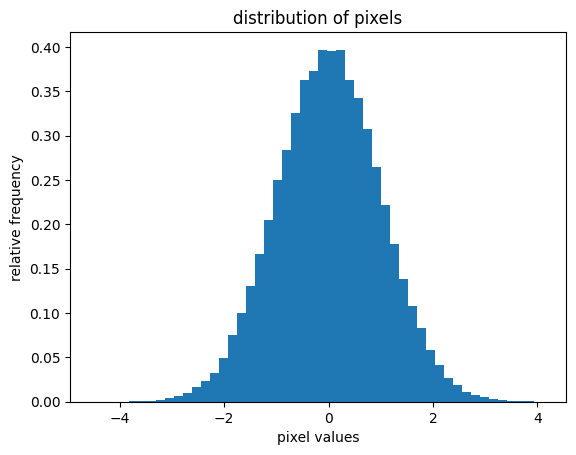

In [7]:
# plot the pixel values
plt.hist(train_dataset_init.cpu().numpy().ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [8]:
print(torch.min(train_dataset_init))
print(train_dataset_init[0])
print(train_dataset_target[0])

tensor(-2.1854, device='cuda:0')
tensor([ 5.0309e-01,  9.0656e-02,  6.2679e-01, -4.3056e-01, -2.8497e-01,
        -2.3972e-01, -5.1595e-02, -2.4730e-01,  2.0386e-01, -3.7464e-01,
        -3.9463e-02, -5.4862e-01,  1.6197e-02, -5.7074e-01, -7.4115e-02,
        -1.1349e+00,  4.2430e-02, -2.2327e-01,  4.6550e-01, -7.1797e-01,
        -4.6994e-01,  2.4937e-01, -3.4988e-01, -3.9033e-01,  4.0616e-01,
        -1.7781e-01,  4.2767e-01, -4.5397e-01,  6.3987e-02,  1.8481e-01,
        -8.0738e-01, -1.5597e-01, -5.2652e-02, -8.0886e-01, -3.3818e-01,
        -2.9000e-01,  8.7347e-02,  7.0799e-01,  4.8196e-01, -1.6600e-01,
        -2.9941e-02, -1.2392e-01,  4.3726e-01, -2.9031e-01, -1.1199e-01,
         4.6034e-01, -1.6730e-01,  1.2942e-01,  7.7759e-01, -5.1554e-01,
         2.4999e-01,  7.1646e-01, -2.5776e-01, -2.8910e-01,  3.8904e-03,
        -7.6927e-01,  3.8800e-01, -4.3277e-01,  2.1813e-01, -7.1277e-01,
        -2.5991e-01,  7.1657e-02,  1.2822e-01, -1.4828e-01, -2.0076e-01,
         7.7260e-0

In [9]:
print(train_dataset_target)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)


In [10]:
print(torch.mean(train_dataset_target.float()))
print(torch.std(train_dataset_target.float()))

tensor(35.2638, device='cuda:0')
tensor(80.6091, device='cuda:0')


In [11]:
class v_model(Module):
    def __init__(self, input_dim, hidden_num):
        super().__init__()
        p_drop = 0.1
        self.NN = Sequential(Linear(input_dim + 1, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Dropout(p_drop),
                            Linear(hidden_num, input_dim, bias=True)
                            )
    
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.NN(inputs)

        return x

In [12]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory

In [13]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in range(inner_iters + 1):
        optimizer.zero_grad()
        indeces = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indeces]
        z0 = batch[:, 0]
        z1 = batch[:, 1]
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)

        pred = rectified_flow.v_model(z_t, t)
        loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())

    return rectified_flow, loss_curve

In [14]:
inner_iters = 10000
input_dim = 784

In [15]:
inner_iters = 10000
input_dim = 784
v_mod = v_model(input_dim, 120)
rectified_flow_1 = RectifiedFlow(v_mod)
pairs_1 = torch.stack([train_dataset_init, train_dataset_target], axis=1)

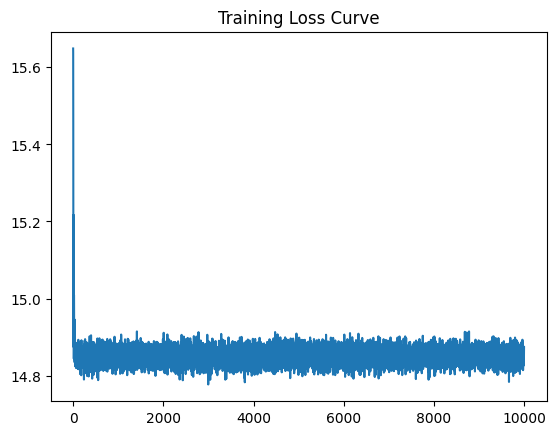

In [16]:
optimizer = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-4, weight_decay=0.01, momentum=0.9)

rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer, pairs_1, batch_size, inner_iters)
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

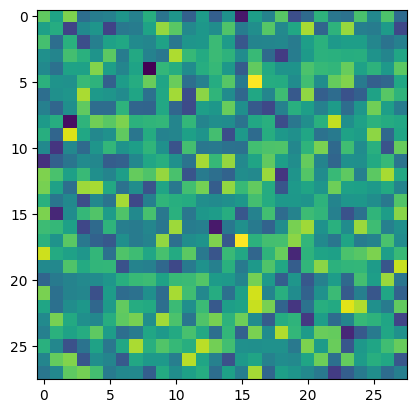

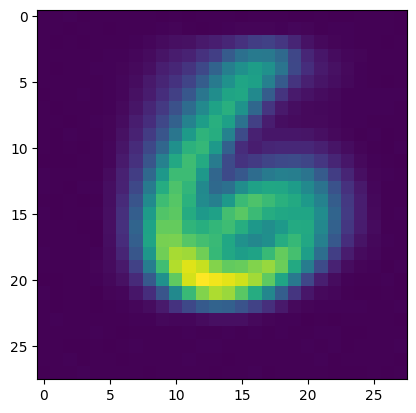

In [17]:
curr_img = 0
img = rectified_flow_1.sample_ode(train_dataset_init[:100], 200)
plt.imshow(train_dataset_init[curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()

In [18]:
print(img[-1][curr_img].reshape(28,28))

tensor([[ 5.0131e-01,  9.8135e-02,  6.5235e-01, -4.0761e-01, -2.8376e-01,
         -2.3493e-01, -7.4007e-02, -2.3254e-01,  2.0192e-01, -4.0310e-01,
         -2.1257e-02, -5.6970e-01,  2.5843e-01, -9.9729e-02, -9.2539e-02,
         -1.1447e+00,  3.7487e-02, -1.9023e-01,  4.6576e-01, -7.0589e-01,
         -4.7433e-01,  2.8420e-01, -3.9678e-01, -3.4905e-01,  4.0671e-01,
         -1.5262e-01,  4.1757e-01, -4.3897e-01],
        [ 8.5847e-02,  1.7104e-01, -8.0953e-01, -1.5087e-01, -5.5346e-02,
         -8.2792e-01, -5.3042e-02,  1.1029e-01,  4.5340e-01,  1.1082e+00,
          1.5620e+00, -7.7735e-02, -3.6710e-01,  7.4355e-02,  1.1575e+00,
          1.6607e+00,  1.9771e+00,  2.0350e+00,  1.0324e+00,  2.3946e+00,
          1.9023e+00, -3.2338e-02,  5.7391e-01,  8.3201e-01, -2.6591e-01,
         -2.8494e-01,  1.4548e-03, -7.7145e-01],
        [ 3.8449e-01, -4.4072e-01,  1.9212e-01, -7.2246e-01, -3.0607e-01,
          7.0773e-02,  4.3332e-01,  6.9940e-01,  2.4671e+00,  5.3817e+00,
          7.64

In [19]:
for i in img:
    print(torch.mean(i))
    print(torch.std(i))

tensor(-0.0013, device='cuda:0')
tensor(0.3882, device='cuda:0')
tensor(0.0337, device='cuda:0')
tensor(0.4909, device='cuda:0')
tensor(0.0688, device='cuda:0')
tensor(0.7063, device='cuda:0')
tensor(0.1031, device='cuda:0')
tensor(0.9633, device='cuda:0')
tensor(0.1380, device='cuda:0')
tensor(1.2341, device='cuda:0')
tensor(0.1728, device='cuda:0')
tensor(1.5110, device='cuda:0')
tensor(0.2073, device='cuda:0')
tensor(1.7919, device='cuda:0')
tensor(0.2422, device='cuda:0')
tensor(2.0750, device='cuda:0')
tensor(0.2766, device='cuda:0')
tensor(2.3595, device='cuda:0')
tensor(0.3106, device='cuda:0')
tensor(2.6466, device='cuda:0')
tensor(0.3445, device='cuda:0')
tensor(2.9322, device='cuda:0')
tensor(0.3781, device='cuda:0')
tensor(3.2193, device='cuda:0')
tensor(0.4130, device='cuda:0')
tensor(3.5073, device='cuda:0')
tensor(0.4475, device='cuda:0')
tensor(3.7952, device='cuda:0')
tensor(0.4818, device='cuda:0')
tensor(4.0854, device='cuda:0')
tensor(0.5166, device='cuda:0')
tensor(

In [20]:
v_mod_2 = v_model(input_dim, 120)
rectified_flow_2 = RectifiedFlow(v_mod_2)
flow_1 = rectified_flow_1.sample_ode(train_dataset_init, 120)
pairs_2 = torch.stack([train_dataset_init, flow_1[:][-1]], axis=1)

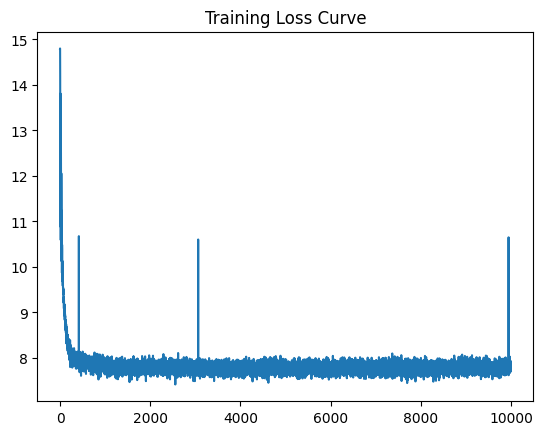

In [21]:
optimizer = torch.optim.SGD(rectified_flow_2.v_model.parameters(), lr=5e-4, weight_decay=0.01, momentum=0.9)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer, pairs_2, batch_size, inner_iters)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

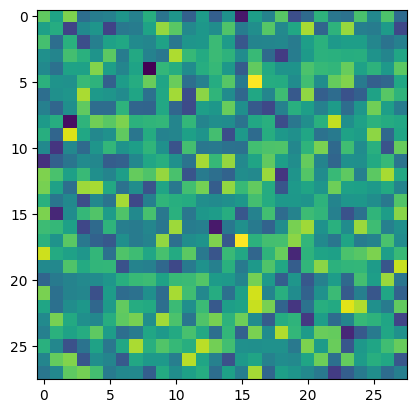

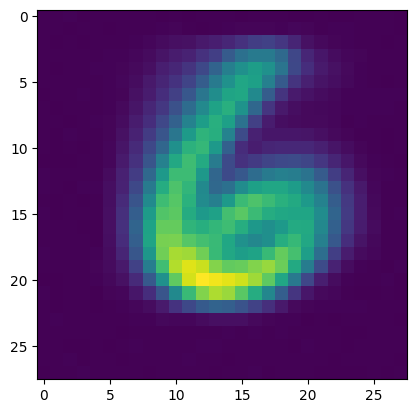

In [23]:
curr_img = 0
img = rectified_flow_2.sample_ode(pairs_1[:100][0], 1)
plt.imshow(pairs_2[curr_img][0].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()

In [9]:
#torch.save(rectified_flow_2, "./models/MNIST_test7_2.pth")
rectified_flow_2 = torch.load("./models/MNIST_test7_2.pth")

In [24]:
v_mod_3 = v_model(input_dim, 120)
rectified_flow_3 = RectifiedFlow(v_mod_3)
flow_2 = rectified_flow_2.sample_ode(train_dataset_init, 100)
pairs_3 = torch.stack([train_dataset_init, flow_2[:][-1]], axis=1)

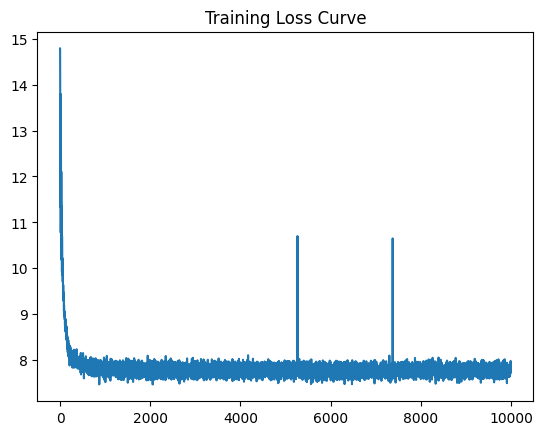

In [25]:
optimizer = torch.optim.SGD(rectified_flow_3.v_model.parameters(), lr=5e-4, weight_decay=0.01, momentum=0.9)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer, pairs_3, batch_size, inner_iters)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

torch.Size([100, 784])


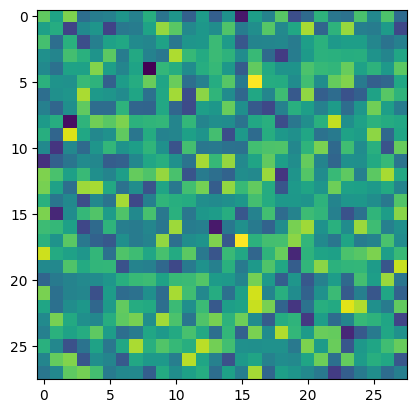

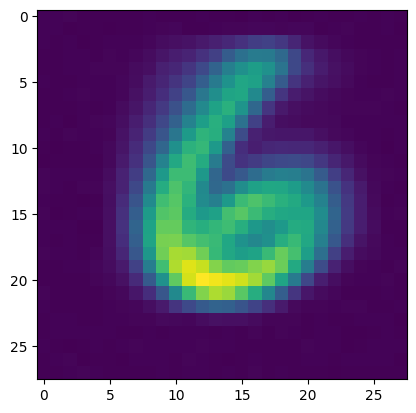

In [26]:
curr_img = 0
img = rectified_flow_3.sample_ode(train_dataset_init[:100], 100)
print(img[-1].shape)
plt.imshow(train_dataset_init[curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[70][curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()